# 1d) Check whether a tweet is attention-worthy

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
import warnings

warnings.filterwarnings("ignore") # Ignore warnings
nltk.download('stopwords') # Load Stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Exploration

In [2]:
nlp = spacy.load("en_core_web_sm") # Load Lemmatizer
cachedStopWords = list(set(stopwords.words("english")))

# Twitter Datasets
df_worthy_train = pd.read_csv("data/1d/CT22_english_1D_attentionworthy_train.tsv", sep='\t')
df_worthy_valid = pd.read_csv("data/1d/CT22_english_1D_attentionworthy_dev.tsv", sep='\t')
df_worthy_test = pd.read_csv("data/1d/CT22_english_1D_attentionworthy_dev_test.tsv", sep='\t')

# Top 3000 most commonly used english words + covid related medical terms (used as vocabulary for the vectorization process)
topwords = pd.read_csv('words.txt', sep=" ", header=None).values[:,0]

In [3]:
print("Test shape: {}\nTrain shape: {}\nValidation shape: {}".format(df_worthy_test.shape, df_worthy_train.shape, df_worthy_valid.shape))
df_worthy_train.head()

Test shape: (909, 5)
Train shape: (3321, 5)
Validation shape: (306, 5)


,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",no_not_interesting
1,COVID-19,1.350166e+18,http://twitter.com/user/status/135016568806166...,Here’s what I’m doing while I wait my turn for...,no_not_interesting
2,COVID-19,1.369750e+18,http://twitter.com/user/status/136974953915491...,"This afternoon, I’m hosting an event with the ...",no_not_interesting
3,COVID-19,1.350165e+18,http://twitter.com/user/status/135016499568693...,"Help shops like mine stay open. Mask up, avoid...",no_not_interesting
4,COVID-19,1.370008e+18,http://twitter.com/user/status/137000807648978...,As part of the ongoing nationwide vaccination ...,no_not_interesting


### Handling imbalanced multiclass text classification

Categories: ['no_not_interesting' 'harmful' 'yes_calls_for_action'
 'yes_blame_authorities' 'yes_discusses_cure' 'yes_discusses_action_taken'
 'yes_asks_question' 'yes_contains_advice' 'yes_other']


<AxesSubplot:title={'center':'Categories vs Number of Documents'}>

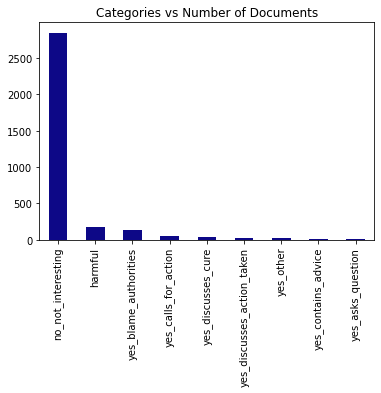

In [4]:
categories = df_worthy_train.class_label.unique()
print('Categories: {}'.format(categories))
df_worthy_train.class_label.value_counts().plot(kind='bar', title='Categories vs Number of Documents', cmap='plasma')

# Sampling

In [5]:
df_worthy_train["class_label"].value_counts()

no_not_interesting            2851
harmful                        173
yes_blame_authorities          138
yes_calls_for_action            48
yes_discusses_cure              42
yes_discusses_action_taken      27
yes_other                       25
yes_contains_advice             12
yes_asks_question                5
Name: class_label, dtype: int64

## Downsampling

In [6]:
label_dfs = {}

for label in df_worthy_train["class_label"].unique():
    label_dfs[label] = df_worthy_train[df_worthy_train["class_label"] == label]

In [7]:
downsampled_dfs = {}
minority_class = min(df_worthy_train["class_label"].value_counts())

for key, val in label_dfs.items():
    downsampled_dfs["downsampled_" + key] = val.sample(n=minority_class)

df_downsampled = pd.concat(downsampled_dfs.values())
df_downsampled["class_label"].value_counts()

no_not_interesting            5
harmful                       5
yes_calls_for_action          5
yes_blame_authorities         5
yes_discusses_cure            5
yes_discusses_action_taken    5
yes_asks_question             5
yes_contains_advice           5
yes_other                     5
Name: class_label, dtype: int64

## Upsampling

In [8]:
upsampled_dfs = {}
majority_class = max(df_worthy_train["class_label"].value_counts())

for key, val in label_dfs.items():
    upsampled_dfs["upsampled_" + key] = val.sample(n=majority_class, replace=True)

df_upsampled = pd.concat(upsampled_dfs.values())
df_upsampled["class_label"].value_counts()

no_not_interesting            2851
harmful                       2851
yes_calls_for_action          2851
yes_blame_authorities         2851
yes_discusses_cure            2851
yes_discusses_action_taken    2851
yes_asks_question             2851
yes_contains_advice           2851
yes_other                     2851
Name: class_label, dtype: int64

## Combination of over- and undersampling

In [9]:
meansampled_dfs = {}
mean_val = df_worthy_train["class_label"].value_counts().mean()

for key, val in label_dfs.items():
    meansampled_dfs["meansampled" + key] = val.sample(n=int(mean_val), replace=True)

df_meansampled = pd.concat(meansampled_dfs.values())
df_meansampled["class_label"].value_counts()

no_not_interesting            369
harmful                       369
yes_calls_for_action          369
yes_blame_authorities         369
yes_discusses_cure            369
yes_discusses_action_taken    369
yes_asks_question             369
yes_contains_advice           369
yes_other                     369
Name: class_label, dtype: int64

#### Creating weights

In [10]:
# https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight= 'balanced', 
                                                       classes = np.unique(df_worthy_train["class_label"]), 
                                                       y = df_worthy_train["class_label"]))

In [11]:
df_worthy_train["class_label"].value_counts()

no_not_interesting            2851
harmful                        173
yes_blame_authorities          138
yes_calls_for_action            48
yes_discusses_cure              42
yes_discusses_action_taken      27
yes_other                       25
yes_contains_advice             12
yes_asks_question                5
Name: class_label, dtype: int64

In [12]:
labels = df_worthy_train["class_label"].value_counts().index.tolist()

In [13]:
# Creating weights
class_weights.sort()
class_weights

df_worthy_train["class_label"].value_counts()

weights = {}
for index, weight in enumerate(class_weights):
    weights[labels[index]] = weight
weights

{'no_not_interesting': 0.1294282707821817,
 'harmful': 2.132947976878613,
 'yes_blame_authorities': 2.6739130434782608,
 'yes_calls_for_action': 7.6875,
 'yes_discusses_cure': 8.785714285714286,
 'yes_discusses_action_taken': 13.666666666666666,
 'yes_other': 14.76,
 'yes_contains_advice': 30.75,
 'yes_asks_question': 73.8}

# Preprocessing

### Emoji Removal

In [14]:
# Function to remove emojies when using the lemmatizer
#https://poopcode.com/how-to-remove-emoji-from-text-in-python/
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

### Custom Tokenizer

In [15]:
def tokenize_text(text, method="stopwords"):
    
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    
    # Split sentence into words
    tokens = []
    for token in ngrams(text.split(), 1):
        word = re.sub(r',', '', token[0]) #Remove commas
        word = re.sub(r'[\!\.\:]$', '', word) #Remove (.!:) at the end of tokens
        word = re.sub(r'#', '', word) #Remove hashtags (not the text)
        if word == "—": continue #Ignore dash
        if word.find("@") != -1: continue #Ignore tags
        tokens.append(word)
    tokens

    # List comprehension to remove stopwords
    if method != "default":
        tokens = [x for x in tokens if x not in cachedStopWords]

    # Perform stemming
    if method == "stemming":
        ps = PorterStemmer()
        tokens = [ps.stem(x) for x in tokens]

    # Perform lemmatization
    if method == "lemmatizer":
        # Remove emojies due to lemmatizer not handling them well
        tokens = [x for x in tokens if remove_emoji(x) == x]
        text = " ".join(tokens)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    return tokens

In [16]:
def tokenize_normal(text):
    return tokenize_text(text, method="default")

def tokenize_stopwords(text):
    return tokenize_text(text, method="stopwords")

def tokenize_stemming(text):
    return tokenize_text(text, method="stemming")

def tokenize_lemmatizer(text):
    return tokenize_text(text, method="lemmatizer")

In [17]:
def tokenize_df(df, text_col, method="default"):
    article_tokens = []
    for i in range(len(df)):
        text = df.iloc[i][text_col].lower()
        article_tokens.append(tokenize_text(text, method))
    df["tokens"] = article_tokens

In [18]:
tokenize_df(df_downsampled, "tweet_text", "lemmatizer")
tokenize_df(df_upsampled, "tweet_text", "lemmatizer")
tokenize_df(df_meansampled, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_train, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_test, "tweet_text", "lemmatizer")

In [19]:
print(df_downsampled.iloc[0]["tokens"], "\n")
print(df_upsampled.iloc[0]["tokens"], "\n")
print(df_meansampled.iloc[0]["tokens"], "\n")
print(df_worthy_train.iloc[0]["tokens"], "\n")
print(df_worthy_test.iloc[0]["tokens"])

['break', 'pre', 'duterte', 'declare', 'walangpasok', 'level', 'metro', 'manila', 'march', '14', 'due', 'covid19', '|via', 'cnn', 'philippines'] 

['china', 'country', 'say', 'launch', 'new', 'programme', 'provide', 'million', 'covid-19', 'vaccine', 'national', 'africa', 'elsewhere', 'overseas', 'accord', 'foreign', 'minister', 'wang', 'yi'] 

['single', '-', 'dose', 'j&amp;j', 'covid-19', 'vaccine', 'administer', 'sat', 'march', '13', 'sun', 'march', '14', '9', 'a.m', '5', 'p.m', 'available', 'number', 'vaccine', 'run', 'anyone', 'already', 'receive', 'dose', 'either', 'moderna', 'pfizer', 'vaccine', 'visit', 'site'] 

['india', "'s", 'gift', '100000', 'covid-19', 'vaccine', 'arrive', 'barbado', 'early', 'today', 'special', 'moment', 'barbadian', 'want', 'thank', 'prime', 'minister', 'modi', 'quick', 'decisive', 'magnanimous', 'action', 'allow', 'we', 'beneficiary', 'vaccine'] 

['senate', 'pass', 'covid', 'relief', '$', '1400', 'relief', 'check', 'fund', 'vaccine', 'money', 'reopen',

# Training

### Bag of words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer # For creating a DTM (discrete values)
from sklearn.feature_extraction.text import TfidfVectorizer # A weighted DTM (fractions)

cv_dict = {}
tfidf_dict = {}
ngram_list = [1,2,3]
for n in ngram_list:
    cv_dict[n] = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(n, n), max_features=5000)
    tfidf_dict[n] = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(n, n), max_features=5000)

In [21]:
tweet_vec = {}
tweet_bow_train = {}
tweet_bow_val = {}
tweet_bow_test = {}

tweet_vec_d = {}
tweet_bow_train_d = {}
tweet_bow_val_d = {}
tweet_bow_test_d = {}

tweet_vec_u = {}
tweet_bow_train_u = {}
tweet_bow_val_u = {}
tweet_bow_test_u = {}

tweet_vec_h = {}
tweet_bow_train_h = {}
tweet_bow_val_h = {}
tweet_bow_test_h = {}
for n in ngram_list:
    #tweet_vec[n] = tfidf_dict[n].fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_vec[n] = cv_dict[n].fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train[n] = tweet_vec[n].transform(df_worthy_train["tweet_text"]) 
    tweet_bow_test[n] = tweet_vec[n].transform(df_worthy_test["tweet_text"]) 
    tweet_bow_val[n] = tweet_vec[n].transform(df_worthy_valid["tweet_text"]) 
    
    # balanced downsample
    #tweet_vec_d[n] = tfidf_dict[n].fit(df_balanced_d["tweet_text"])
    tweet_vec_d[n] = cv_dict[n].fit(df_downsampled["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_d[n] = tweet_vec_d[n].transform(df_downsampled["tweet_text"]) 
    tweet_bow_test_d[n] = tweet_vec_d[n].transform(df_worthy_test["tweet_text"]) 
    tweet_bow_val_d[n] = tweet_vec_d[n].transform(df_worthy_valid["tweet_text"]) 
    
    # balanced upsample
    #tweet_vec_u[n] = tfidf_dict[n].fit(df_balanced_u["tweet_text"]) 
    tweet_vec_u[n] = cv_dict[n].fit(df_upsampled["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_u[n] = tweet_vec_u[n].transform(df_upsampled["tweet_text"]) 
    tweet_bow_test_u[n] = tweet_vec_u[n].transform(df_worthy_test["tweet_text"]) 
    tweet_bow_val_u[n] = tweet_vec_u[n].transform(df_worthy_valid["tweet_text"])
    
    # balanced hybridsample
    #tweet_vec_h[n] = tfidf_dict[n].fit(df_balanced_h["tweet_text"])
    tweet_vec_h[n] = cv_dict[n].fit(df_meansampled["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_h[n] = tweet_vec_h[n].transform(df_meansampled["tweet_text"]) 
    tweet_bow_test_h[n] = tweet_vec_h[n].transform(df_worthy_test["tweet_text"]) 
    tweet_bow_val_h[n] = tweet_vec_h[n].transform(df_worthy_valid["tweet_text"]) 

### Dummy prediction

In [104]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

for n in ngram_list:
    print("--------Unbalanced--------")
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train[n], df_worthy_train["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"], average="weighted")
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Downsampled--------")
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train_d[n], df_downsampled["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test_d[n]), df_worthy_test["class_label"], average="weighted")
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(dummy_clf.predict(tweet_bow_test_d[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(dummy_clf.predict(tweet_bow_test_d[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Upsampled--------")
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train_u[n], df_upsampled["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test_u[n]), df_worthy_test["class_label"], average="weighted")
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(dummy_clf.predict(tweet_bow_test_u[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(dummy_clf.predict(tweet_bow_test_u[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Meansampled--------")
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train_h[n], df_meansampled["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test_h[n]), df_worthy_test["class_label"], average="weighted")
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(dummy_clf.predict(tweet_bow_test_h[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(dummy_clf.predict(tweet_bow_test_h[n]), df_worthy_test["class_label"], average="macro")
    print("Dummy Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
1-gram Priors: [0.05209274 0.85847636 0.00150557 0.04155375 0.01445348 0.00361337
 0.00813008 0.01264679 0.00752785]
Dummy F1-Score for 1-gram: 91.98%
Dummy Precision-Score for 1-gram: 11.11%
Dummy Recall-Score for 1-gram: 9.46%
--------Downsampled--------
1-gram Priors: [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
Dummy F1-Score for 1-gram: 11.41%
Dummy Precision-Score for 1-gram: 11.11%
Dummy Recall-Score for 1-gram: 0.67%
--------Upsampled--------
1-gram Priors: [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
Dummy F1-Score for 1-gram: 11.41%
Dummy Precision-Score for 1-gram: 11.11%
Dummy Recall-Score for 1-gram: 0.67%
--------Meansampled--------
1-gram Priors: [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
Dummy F1-Score for 1-gram: 11.41%
Dummy Precision-Score for 1-gram: 11.11%
Dummy Recall

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

lr_w = LogisticRegression(class_weight=weights)
lr_n = LogisticRegression(class_weight=None)

lr_d = LogisticRegression(class_weight=None)
lr_u = LogisticRegression(class_weight=None)
lr_h = LogisticRegression(class_weight=None)

In [50]:
for n in ngram_list:
    lr_w.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])
    lr_n.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])
    
    print("--------Custom weight--------")
    f1_score = metrics.f1_score(lr_w.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(lr_w.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(lr_w.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------No weight--------")
    f1_score = metrics.f1_score(lr_n.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(lr_n.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(lr_n.predict(tweet_bow_val[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    print("--------------------------------------")

--------Custom weight--------
Logistic Regression F1-Score for 1-gram: 83.52%
Logistic Regression Precision-Score for 1-gram: 24.48%
Logistic Regression Recall-Score for 1-gram: 22.38%
--------No weight--------
Logistic Regression F1-Score for 1-gram: 90.42%
Logistic Regression Precision-Score for 1-gram: 14.08%
Logistic Regression Recall-Score for 1-gram: 18.24%
--------------------------------------
--------Custom weight--------
Logistic Regression F1-Score for 2-gram: 78.15%
Logistic Regression Precision-Score for 2-gram: 25.08%
Logistic Regression Recall-Score for 2-gram: 21.84%
--------No weight--------
Logistic Regression F1-Score for 2-gram: 91.87%
Logistic Regression Precision-Score for 2-gram: 11.56%
Logistic Regression Recall-Score for 2-gram: 13.49%
--------------------------------------
--------Custom weight--------
Logistic Regression F1-Score for 3-gram: 80.52%
Logistic Regression Precision-Score for 3-gram: 13.2%
Logistic Regression Recall-Score for 3-gram: 13.31%
------

In [48]:
for n in ngram_list:
    lr_d.fit(tweet_bow_train_d[n].toarray(), df_downsampled["class_label"])
    lr_u.fit(tweet_bow_train_u[n].toarray(), df_upsampled["class_label"])
    lr_h.fit(tweet_bow_train_h[n].toarray(), df_meansampled["class_label"])
    
    print("--------Downsampled--------")
    f1_score = metrics.f1_score(lr_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(lr_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(lr_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Upsampled--------")
    f1_score = metrics.f1_score(lr_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(lr_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(lr_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Meansampled--------")
    f1_score = metrics.f1_score(lr_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(lr_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(lr_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))

--------Downsampled--------
Logistic Regression F1-Score for 1-gram: 4.96%
Logistic Regression Precision-Score for 1-gram: 9.52%
Logistic Regression Recall-Score for 1-gram: 11.22%
--------Upsampled--------
Logistic Regression F1-Score for 1-gram: 82.26%
Logistic Regression Precision-Score for 1-gram: 20.17%
Logistic Regression Recall-Score for 1-gram: 19.83%
--------Meansampled--------
Logistic Regression F1-Score for 1-gram: 72.63%
Logistic Regression Precision-Score for 1-gram: 27.67%
Logistic Regression Recall-Score for 1-gram: 18.72%
--------Downsampled--------
Logistic Regression F1-Score for 2-gram: 1.87%
Logistic Regression Precision-Score for 2-gram: 15.44%
Logistic Regression Recall-Score for 2-gram: 9.98%
--------Upsampled--------
Logistic Regression F1-Score for 2-gram: 84.15%
Logistic Regression Precision-Score for 2-gram: 11.95%
Logistic Regression Recall-Score for 2-gram: 11.96%
--------Meansampled--------
Logistic Regression F1-Score for 2-gram: 86.18%
Logistic Regressi

In [49]:
n = 2
print("--------Meansampled--------")
lr_h.fit(tweet_bow_train_h[n].toarray(), df_meansampled["class_label"])
f1_score = metrics.f1_score(lr_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="weighted")
print("Logistic Regression F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
precision_score = metrics.precision_score(lr_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="macro")
print("Logistic Regression Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
recall_score = metrics.recall_score(lr_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="macro")
print("Logistic Regression Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))

--------Meansampled--------
Logistic Regression F1-Score for 2-gram: 85.84%
Logistic Regression Precision-Score for 2-gram: 19.26%
Logistic Regression Recall-Score for 2-gram: 21.03%


### K-nearest neighbor

In [26]:
# https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)#, weights=class_weights)
knn_d = KNeighborsClassifier(n_neighbors=9)#, weights=class_weights)
knn_u = KNeighborsClassifier(n_neighbors=9)#, weights=class_weights)
knn_h = KNeighborsClassifier(n_neighbors=9)#, weights=class_weights)


In [46]:
for n in ngram_list:
    knn.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])
    knn_d.fit(tweet_bow_train_d[n].toarray(), df_downsampled["class_label"])
    knn_u.fit(tweet_bow_train_u[n].toarray(), df_upsampled["class_label"])
    knn_h.fit(tweet_bow_train_h[n].toarray(), df_meansampled["class_label"])
    
    print("--------Unbalanced--------")
    f1_score = metrics.f1_score(knn.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(knn.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(knn.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Downsampled--------")
    f1_score = metrics.f1_score(knn_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(knn_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(knn_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Upsampled--------")
    f1_score = metrics.f1_score(knn_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(knn_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(knn_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Meansampled--------")
    f1_score = metrics.f1_score(knn_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(knn_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(knn_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
KNN F1-Score for 1-gram: 91.98%
KNN Precision-Score for 1-gram: 11.11%
KNN Recall-Score for 1-gram: 9.46%
--------Downsampled--------
KNN F1-Score for 1-gram: 2.3%
KNN Precision-Score for 1-gram: 12.15%
KNN Recall-Score for 1-gram: 9.37%
--------Upsampled--------
KNN F1-Score for 1-gram: 76.27%
KNN Precision-Score for 1-gram: 13.89%
KNN Recall-Score for 1-gram: 11.84%
--------Meansampled--------
KNN F1-Score for 1-gram: 4.23%
KNN Precision-Score for 1-gram: 9.84%
KNN Recall-Score for 1-gram: 14.2%
--------------------------------------
--------Unbalanced--------
KNN F1-Score for 2-gram: 91.98%
KNN Precision-Score for 2-gram: 11.11%
KNN Recall-Score for 2-gram: 9.46%
--------Downsampled--------
KNN F1-Score for 2-gram: 0.66%
KNN Precision-Score for 2-gram: 11.19%
KNN Recall-Score for 2-gram: 11.15%
--------Upsampled--------
KNN F1-Score for 2-gram: 83.65%
KNN Precision-Score for 2-gram: 12.88%
KNN Recall-Score for 2-gram: 12.09%
--------Meansampled--------
KNN

In [47]:
n = 3
print("--------Meansampled--------")
f1_score = metrics.f1_score(knn_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="weighted")
print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
precision_score = metrics.precision_score(knn_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="macro")
print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
recall_score = metrics.recall_score(knn_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"], average="macro")
print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))

--------Meansampled--------
KNN F1-Score for 3-gram: 91.53%
KNN Precision-Score for 3-gram: 11.59%
KNN Recall-Score for 3-gram: 24.3%


### Naive Bayes

In [107]:
from sklearn.naive_bayes import MultinomialNB # suited for classification with discrete features
from sklearn.naive_bayes import ComplementNB 

clf = ComplementNB()
clf_d = MultinomialNB()
clf_u = MultinomialNB()
clf_h = MultinomialNB()

for n in ngram_list:
    print("--------Unbalanced--------")
    clf.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])
    f1_score = metrics.f1_score(clf.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="weighted")
    print("Complement F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(clf.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="macro")
    print("Complement precision for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(clf.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"], average="macro")
    print("Complement recall for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Downsampled--------")
    clf_d.fit(tweet_bow_train_d[n].toarray(), df_downsampled["class_label"])
    f1_score = metrics.f1_score(clf_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(clf_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(clf_d.predict(tweet_bow_val_d[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Upsampled--------")
    clf_u.fit(tweet_bow_train_u[n].toarray(), df_upsampled["class_label"])
    f1_score = metrics.f1_score(clf_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("Complement F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(clf_u.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Complement precision for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(clf.predict(tweet_bow_val_u[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("Complement recall for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    
    print("--------Meansampled--------")
    clf_h.fit(tweet_bow_train_h[n].toarray(), df_meansampled["class_label"])
    f1_score = metrics.f1_score(clf_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="weighted")
    print("KNN F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    precision_score = metrics.precision_score(clf_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Precision-Score for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
    recall_score = metrics.recall_score(clf_h.predict(tweet_bow_val_h[n].toarray()), df_worthy_valid["class_label"], average="macro")
    print("KNN Recall-Score for {}-gram: {}%".format(n, round(recall_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
Complement F1-Score for 1-gram: 81.31%
Complement precision for 1-gram: 25.06%
Complement recall for 1-gram: 25.45%
--------Downsampled--------
KNN F1-Score for 1-gram: 7.59%
KNN Precision-Score for 1-gram: 8.43%
KNN Recall-Score for 1-gram: 11.26%
--------Upsampled--------
Complement F1-Score for 1-gram: 81.7%
Complement precision for 1-gram: 24.19%
Complement recall for 1-gram: 11.7%
--------Meansampled--------
KNN F1-Score for 1-gram: 54.2%
KNN Precision-Score for 1-gram: 31.58%
KNN Recall-Score for 1-gram: 17.25%
--------------------------------------
--------Unbalanced--------
Complement F1-Score for 2-gram: 71.3%
Complement precision for 2-gram: 20.27%
Complement recall for 2-gram: 18.08%
--------Downsampled--------
KNN F1-Score for 2-gram: 8.12%
KNN Precision-Score for 2-gram: 13.28%
KNN Recall-Score for 2-gram: 11.41%
--------Upsampled--------
Complement F1-Score for 2-gram: 67.52%
Complement precision for 2-gram: 24.08%
Complement recall for 2-gram: 

In [45]:
n = 1
print("--------Upsampled--------")
clf_u.fit(tweet_bow_train_u[n].toarray(), df_upsampled["class_label"])
f1_score = metrics.f1_score(clf_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"], average="weighted")
print("Complement F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
precision_score = metrics.precision_score(clf_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"], average="macro")
print("Complement precision for {}-gram: {}%".format(n, round(precision_score * 100, 2)))
    
recall_score = metrics.recall_score(clf.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"], average="macro")
print("Complement recall for {}-gram: {}%".format(n, round(recall_score * 100, 2)))

--------Upsampled--------
Complement F1-Score for 1-gram: 78.42%
Complement precision for 1-gram: 26.54%
Complement recall for 1-gram: 11.25%


<br><br><br>

<hr>


# (Multi-Class) Text Classification using Bidirectional LSTM

Source: https://medium.com/analytics-vidhya/author-multi-class-text-classification-using-bidirectional-lstm-keras-c9a533a1cc4a

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import tensorflow as tf
print(tf.__version__)

2.8.0


In [90]:
def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return " ".join(tokens)
df_worthy_train["tweet_text"] = list(map(getLemmText, df_worthy_train["tweet_text"]))

In [91]:
EMBEDDING_DIMENSION = 64
VOCABULARY_SIZE = 16000
MAX_LENGTH = 100
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [92]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(df_worthy_train["tweet_text"]) + list(df_worthy_train["class_label"]))

In [93]:
xtrain_sequences = tokenizer.texts_to_sequences(df_worthy_train["tweet_text"])
xtest_sequences = tokenizer.texts_to_sequences(df_worthy_train["class_label"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
dict(list(word_index.items())[0:10])

Vocabulary size: 15745


{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'vaccine': 4,
 't': 5,
 'co': 6,
 'to': 7,
 'http': 8,
 'not': 9,
 'no': 10}

In [103]:
print(xtrain_sequences[100])

[40, 50, 369, 24, 5, 1084, 70, 4, 122, 3, 70, 351, 257, 122, 26, 2, 158, 7, 90, 36, 2, 521, 72, 317, 17, 12, 14, 3696]


In [95]:
xtrain_pad = sequence.pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xtest_pad = sequence.pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
print(len(xtrain_sequences[0]))
print(len(xtrain_pad[0]))
print(xtrain_pad[100])

51
100
[  40   50  369   24    5 1084   70    4  122    3   70  351  257  122
   26    2  158    7   90   36    2  521   72  317   17   12   14 3696
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [96]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(list(df_worthy_valid["tweet_text"]))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(df_worthy_valid["tweet_text"]))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(df_worthy_valid["class_label"]))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

[1051, 607, 147, 19, 70, 1052, 415, 30, 8, 10, 42, 200, 6, 1, 416, 29, 1053, 2, 1054, 608, 18, 1055, 417, 1056, 2, 1057, 416, 251, 20, 64, 418, 96, 7, 19, 419, 70, 113, 18, 20, 17, 1, 201]
[1058, 609, 420, 14, 56, 307, 8, 10, 7, 11, 1059, 6, 202, 308, 309, 1060, 2, 1061, 89, 2, 119, 5, 3, 4, 1062]
[8, 10, 25, 1063, 22, 201, 9, 252, 2, 18, 8, 10, 7, 77, 6, 421, 2, 159, 6, 160, 23, 14, 22, 148, 6, 422, 65, 22, 1064, 2, 97, 22, 161, 5, 3, 4, 1065]
(306,)


In [97]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_article(text):
 return " ".join([reverse_word_index.get(i, "?") for i in text])
print(decode_article(xtrain_pad[11]))

dear moms for the love of god and family do not let anyone jab your baby with the experimental covid 19 vaccine http t co 0lizf4drgq ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [98]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [99]:
# TODO: below codeblock doesnt work due to these two fucks having the wrong datatype
#xtrain_pad = np.asarray(xtrain_pad).astype(np.int_)
xtrain_pad = np.asarray(xtrain_pad).astype('float32')

#training_label_seq

#these too?
#xtest_pad
#test_label_seq

In [100]:
xtrain_pad.shape

(3321, 100)

In [101]:
training_label_seq.shape

(306,)

In [102]:
num_epochs = 10
history = model.fit(xtrain_pad, training_label_seq, epochs=num_epochs, validation_data=(xtest_pad, test_label_seq), verbose=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
graph_plots(history, "accuracy")
graph_plots(history, "loss")

NameError: name 'history' is not defined